# SAR Linear Discriminant Function Analysis

## Spatially Adjusted Regression - Two Group Discriminant Function Analysis

Ordinary Least Squares vs Spatial Simultaneous Autoregressive Error Model

In this practice, it is assumed that we are working under the normal probability model. The goals of this practice are to: 

a) evaluate a standard OLS regression using a binary response variable (2 groups) when spatial autocorrelation may be present and 

b)evaluate the same relationships given the ability to adjust for spatial autocorrelation using a spatial simultaneous autoregressive error model.

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','car','RColorBrewer','MASS','geoR')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
“no DISPLAY variable so Tk is not available”

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US Ag. Census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the excel and/or pdf file).

In this practice, a variable 'y12_M082_1' indicating acres of irrigated land as percent of land in farms acreage (year 2012) will be evaluated as will a variable named 'coastal' which was added to indicate which counties fall on the coast of the U.S. The 'coastal' variable is set to 1 for counties falling along the coastal regions of the U.S. For all other cases, 'coastal' is either zero or na. First, read in the dataset. It is not really that large, but may take some time to load remotely.

In [2]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California. 

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is provided. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state.  For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In this dataset, the 'atlas_stco' field contains the fips code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with the fips code of California ('06').

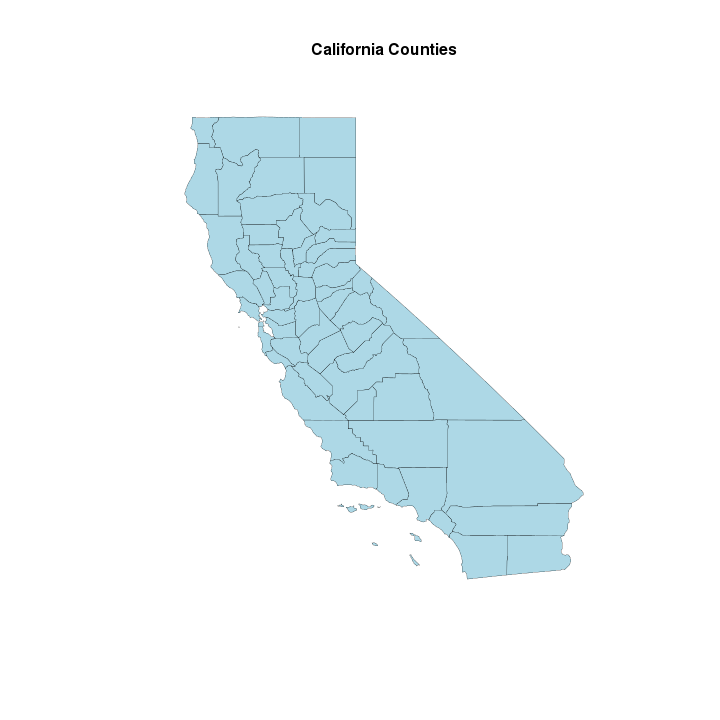

In [3]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

#plot the state selected
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features

Generate neighborhoods for each feature according to the Queen's Criterion.  Then test the neighborhoods to see if they are valid.  Retain only the features with valid neighborhoods.

In [4]:
#Identify the neighbors of each feature
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

#Select features with at least one neighbor
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

### Configure Variables to Analyze

In this case, the explanatory variable is set to 'y12_M082_1'.  A binary (0/1) response variable is used to indicate which counties border the coast (1 if they do, 0 or <NA> otherwise). Thus, the original 'coastal' variable needs to be re-worked to change null values to 0.

In [5]:
head(inFeaturesSubset$coastal)

[1]  1 NA NA NA NA NA

In [6]:
#set coastal variable = 0 if null
inFeaturesSubset$coastal[is.na(inFeaturesSubset$coastal)] <- 0

head(inFeaturesSubset$coastal)

[1] 1 0 0 0 0 0

In [7]:
#set response variables
YVar <- inFeaturesSubset$coastal

# explanatory variable
# 'y12_M082_1' indicating acres of irrigated land as percent of land in farms acreage (year 2012) 
Exp1 <- inFeaturesSubset$y12_M082_1

In [8]:
head(YVar)

[1] 1 0 0 0 0 0

In [9]:
head(Exp1)

[1]  5.00  0.00  7.30 52.40  2.13 57.58

### Plot Observed Response Variables

Visualize the two categories of counties.

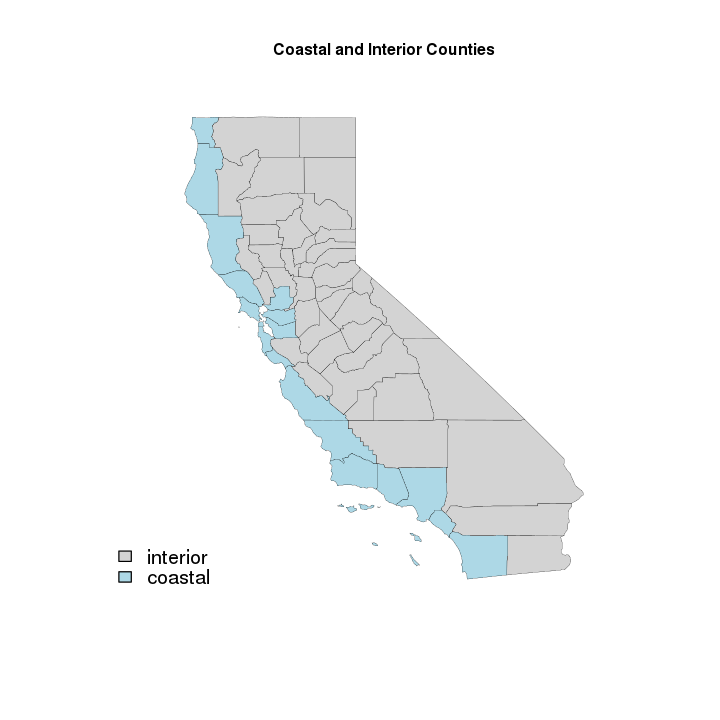

In [10]:
#assign colors to categories
pal <- c("lightgray","lightblue")
cols <- pal[round(inFeaturesSubset@data$coastal)+1]

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="Coastal and Interior Counties",cex.main=.8)
leg <- c("interior", "coastal")
legend("bottomleft", fill=pal, legend=leg, bty="n")

### Plot Explanatory Variable

Visualize the geographic distribution of the explanatory variable.

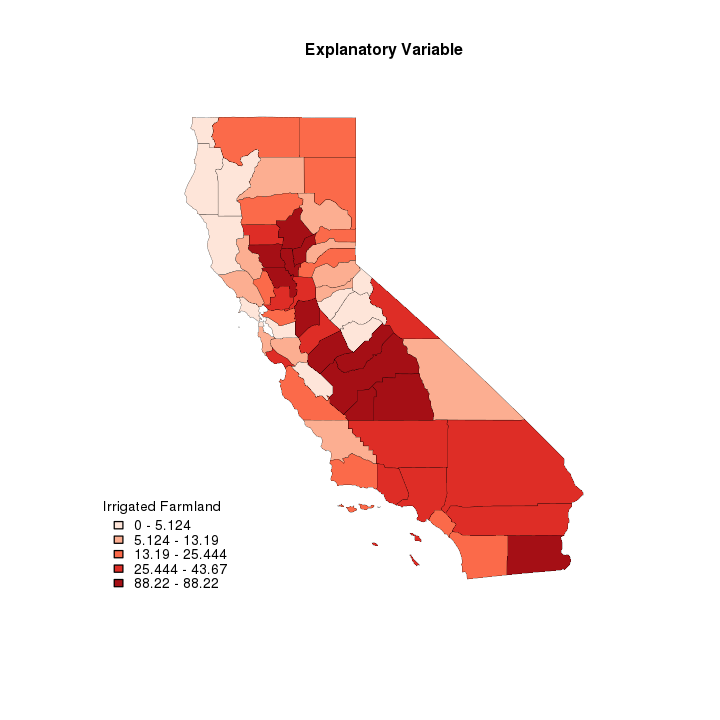

In [11]:
#classify the variable
numcat <- 5
cate <- classIntervals(Exp1, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Explanatory Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Irrigated Farmland",cex=.7)

## Examine Test Statistics for Autocorrelation

Test the explanatory variable for spatial autocorrelation using the Moran and Geary global tests.  

It looks like the Moran test is significant and is greater than zero. Remember what that means?

In [13]:
#run autocorrelation tests
moran.test(YVar, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 4.1497, p-value = 1.665e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.321578100      -0.017543860       0.006678572 


In [14]:
geary.test(YVar, inFeaturesSubset.listb)


	Geary C test under randomisation

data:  YVar 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 5.1705, p-value = 1.167e-07
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.549003623       1.000000000       0.007608226 


## Assess the difference between ordinary regression and SAR

Evaluate the differences between OLS regression and SAR whenever a binary response variable is involved. First, conduct an ordinary linear regression. Take a note of the R-square and standard errors that result.

In [15]:
#Conduct a two-group discriminant function analysis using a binary response variable using linear regression specification
YVar.lm <- lm(YVar ~ Exp1, data=inFeaturesSubset)
summary(YVar.lm)


Call:
lm(formula = YVar ~ Exp1, data = inFeaturesSubset)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4824 -0.3856 -0.1690  0.5366  0.8233 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.482443   0.090631   5.323 1.86e-06 ***
Exp1        -0.007070   0.002838  -2.491   0.0157 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4467 on 56 degrees of freedom
Multiple R-squared:  0.09975,	Adjusted R-squared:  0.08367 
F-statistic: 6.205 on 1 and 56 DF,  p-value: 0.01573


### Evaluate Autocorrelation of OLS Residuals

Retrieve the residuals from the OLS model. This can be done using the residuals() function (stats library). Next, apply a Moran test for spatial autocorrelation in the residuals.

Note the test is highly significant, indicating the null hypothesis can be rejected. Thus, it is clear that the residuals contain a high level of spatial autocorrelation.

In [16]:
#retrieve residuals from OLS model
YVar.lm.res <- residuals(YVar.lm)

#conduct Moran test
moran.test(YVar.lm.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 4.1231, p-value = 1.869e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.319272957      -0.017543860       0.006673435 


## Next, Apply a Spatial Simultaneous Autoregressive model

Specify a SAR model. This can be done using the errorsarlm() function (spdep library).

Note the differences in the results of the two models. Here, the standard errors in the SAR specification differ from those in the OLS model. Also, the rho (lambda) parameter of the SAR model is positive and highly significant. This is evidence that the dependent variable may be afflicted by a high level of spatial autocorrelation. How are the coefficients on the variables similar or different? Are the coefficients significant in both model specifications?

In [17]:
#conduct a SAR specification using a binary response variable
YVar.sar <- errorsarlm(YVar ~ Exp1,listw=inFeaturesSubset.listw)
summary(YVar.sar)


Call:errorsarlm(formula = YVar ~ Exp1, listw = inFeaturesSubset.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.550233 -0.221003 -0.085691  0.351917  0.643909 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.5131822  0.1607223   3.193 0.001408
Exp1        -0.0059185  0.0024396  -2.426 0.015264

Lambda: 0.70378, LR test value: 20.802, p-value: 5.0936e-06
Asymptotic standard error: 0.10006
    z-value: 7.0334, p-value: 2.0153e-12
Wald statistic: 49.469, p-value: 2.0153e-12

Log likelihood: -24.14277 for error model
ML residual variance (sigma squared): 0.11643, (sigma: 0.34122)
Number of observations: 58 
Number of parameters estimated: 4 
AIC: 56.286, (AIC for lm: 75.087)


## Evaluate Autocorrelation of SAR Residuals

Examine the residuals obtained from the SAR specification. Apply the Moran test statistic to test for spatial autocorrelation in the residuals. 

Note that the Moran test is not significant, indicating that the null hypothesis cannot be rejected. Thus, significant spatial autocorrelation among the residuals no longer exists.

In [18]:
#retrieve residuals from SAR model
YVar.sar.res <- residuals(YVar.sar)

#conduct Moran test
moran.test(YVar.sar.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.sar.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 0.78202, p-value = 0.2171
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.046133524      -0.017543860       0.006630298 


### Plot SAR Fitted Values

The fitted values (the difference between the reponse variable and the residuals) from the SAR model are output to a field named 'fitted' associated with the SAR output. Let's evaluate the geographic distribution of these fitted values.

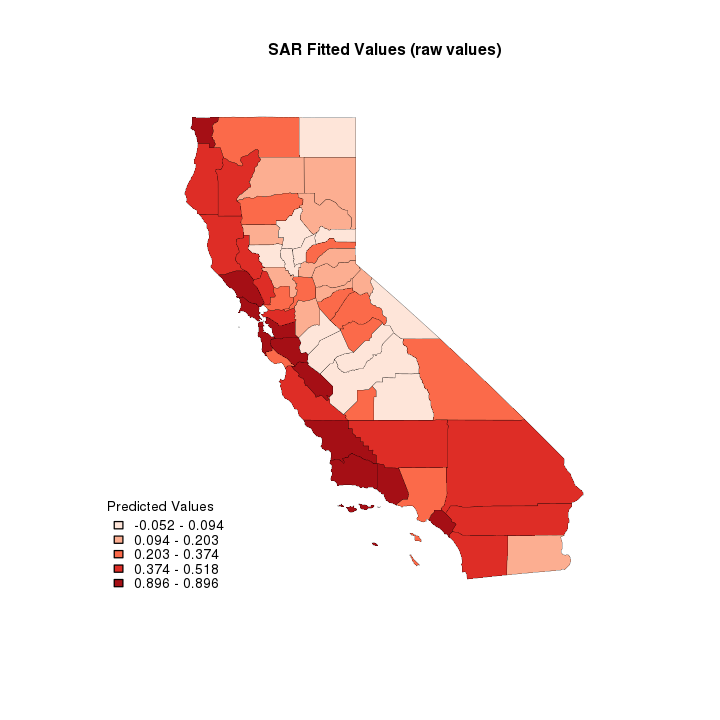

In [19]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sar$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="SAR Fitted Values (raw values)",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)

### Plot Rounded SAR Fitted Values

Remember, that the response variable is actually binary (0,1) in this case. Thus, it might be preferable to visualize the fitted values as 0,1 values as well. To do this, simply round the fitted variables and map to two categories.

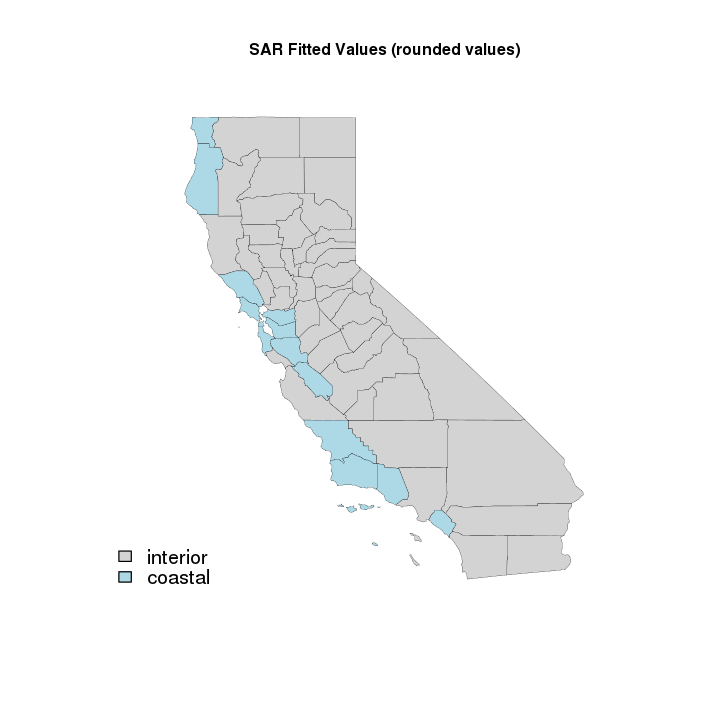

In [20]:
#round the fitted values
rndvalues <- round(YVar.sar$fitted)
pal <- c("lightgray","lightblue")
cols <- pal[rndvalues + 1]

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="SAR Fitted Values (rounded values)",cex.main=.8)
leg <- c("interior", "coastal")
legend("bottomleft", fill=pal, legend=leg, bty="n")